In this notebook we will be attempting to reshape the problem a bit. Instead of calculating air quality on an hourly level, we're instead going to use more traditional machine learning models in an attempt to classify if a future time period has poor air quality. The idea here is that while it may be hard to calculate exact air quality levels when there are so many outliers, we may be able to instead simply tell residents when we think conditions will be bad.

In [643]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler

In [602]:
aqi_df = pd.read_csv("../data/sh_bell/combined_meteor_and_sample.csv", index_col='Unnamed: 0', parse_dates=True)

In [603]:
aqi_df.drop(columns = ['AWD_cos', 'AWD_sin'], inplace=True)

In [604]:
aqi_df.head()

,AWS Mph WVc,Gust Mph Max,AvgT Deg_F Avg,ABP InHg Avg,Sample Value
2017-04-01 00:00:00,5.989,15.55,38.74,29.41,4.0
2017-04-01 01:00:00,5.059,11.30,39.46,29.44,6.0
2017-04-01 02:00:00,5.390,11.30,39.08,29.45,7.0
2017-04-01 03:00:00,5.233,11.59,38.95,29.47,6.0
2017-04-01 04:00:00,3.614,8.68,38.86,29.49,8.0


In [605]:
aqi_df['weekday'] = (aqi_df.index.dayofweek < 5).astype(int)
aqi_df['work_hour'] = ((aqi_df.index.hour >= 5) & (aqi_df.index.hour <=15)).astype(int)
aqi_df.head()

,AWS Mph WVc,Gust Mph Max,AvgT Deg_F Avg,ABP InHg Avg,Sample Value,weekday,work_hour
2017-04-01 00:00:00,5.989,15.55,38.74,29.41,4.0,0,0
2017-04-01 01:00:00,5.059,11.30,39.46,29.44,6.0,0,0
2017-04-01 02:00:00,5.390,11.30,39.08,29.45,7.0,0,0
2017-04-01 03:00:00,5.233,11.59,38.95,29.47,6.0,0,0
2017-04-01 04:00:00,3.614,8.68,38.86,29.49,8.0,0,0


In [662]:
def df_shift(df, n_lags=1, n_obs=1):
    """
    Returns a dataframe with n_lags for all variables and n_obs for the sample value
    """
    n_vars = df.shape[1]
    cols, col_names = [], []
    # lags
    for i in range(n_lags, 0, -1):
        cols.append(df.shift(i))
        col_names += [f'{col} (t-{i})' for col in df.columns]
    # observations
    for i in range(0, n_obs):
        cols.append(df['Sample Value'].shift(-i))
        if i == 0:
            col_names.append('Sample Value (t)')
        else:
            col_names.append(f'Sample Value (t+{i})')
            
    shifted_df = pd.concat(cols, axis=1)
    shifted_df.columns = col_names
    shifted_df.dropna(inplace=True)
    
    return shifted_df

With this function, we can generate dataframes that have features from t - n_lags to t - 1, and observations from t to t + n_obs.

In [663]:
shifted_aqi_df = df_shift(aqi_df.copy(), 24, 1)
shifted_aqi_df.head()

,AWS Mph WVc (t-24),Gust Mph Max (t-24),AvgT Deg_F Avg (t-24),ABP InHg Avg (t-24),Sample Value (t-24),weekday (t-24),work_hour (t-24),AWS Mph WVc (t-23),Gust Mph Max (t-23),AvgT Deg_F Avg (t-23),...,weekday (t-2),work_hour (t-2),AWS Mph WVc (t-1),Gust Mph Max (t-1),AvgT Deg_F Avg (t-1),ABP InHg Avg (t-1),Sample Value (t-1),weekday (t-1),work_hour (t-1),Sample Value (t)
2017-04-02 00:00:00,5.989,15.55,38.74,29.41,4.0,0.0,0.0,5.059,11.300,39.46,...,0.0,0.0,1.278,2.788,43.04,29.58,29.0,0.0,0.0,24.0
2017-04-02 01:00:00,5.059,11.30,39.46,29.44,6.0,0.0,0.0,5.390,11.300,39.08,...,0.0,0.0,1.717,2.964,42.08,29.58,24.0,0.0,0.0,16.0
2017-04-02 02:00:00,5.390,11.30,39.08,29.45,7.0,0.0,0.0,5.233,11.590,38.95,...,0.0,0.0,1.435,3.524,42.58,29.57,16.0,0.0,0.0,16.0
2017-04-02 03:00:00,5.233,11.59,38.95,29.47,6.0,0.0,0.0,3.614,8.680,38.86,...,0.0,0.0,1.536,4.050,42.09,29.54,16.0,0.0,0.0,11.0
2017-04-02 04:00:00,3.614,8.68,38.86,29.49,8.0,0.0,0.0,2.051,4.716,36.87,...,0.0,0.0,2.768,4.996,42.13,29.53,11.0,0.0,0.0,10.0


Now, we'll bin the sample values at times t based on their concentrations. There are no defined standards for 1 hour levels that I could find. And as discussed in the readme, the EPA is already rather conservative with the 24 hour levels that they have defined. Here, I'll be rather conservative and say that anything over 50 $\mu g / m^{3}$ should be considered harmful.

In [664]:
shifted_aqi_df['harmful'] = (shifted_aqi_df['Sample Value (t)'] > 30).astype(int)
shifted_aqi_df.drop('Sample Value (t)', axis=1, inplace=True)

In [665]:
shifted_aqi_df.reset_index(inplace=True)
shifted_aqi_df.drop('index', axis=1, inplace=True)

In [666]:
shifted_aqi_df['harmful'].value_counts()

0    16802
1     6550
Name: harmful, dtype: int64

We can see here that there's a little bit of a class imbalance. This will maybe be addressed with random undersampling.

In [667]:
cat_names = ['weekday', 'work_hour']
cat_cols = []
for name in cat_names:
    for col in shifted_aqi_df.columns:
        if name in col:
            cat_cols.append(col)

In [668]:
X = shifted_aqi_df[shifted_aqi_df.columns[:-1]]
y = shifted_aqi_df[shifted_aqi_df.columns[-1]]

In [669]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)
X_train_num = X_train.drop(cat_cols, axis=1)
X_train_cat = X_train[cat_cols]
X_test_num = X_test.drop(cat_cols, axis=1)
X_test_cat = X_test[cat_cols]

X_scaler = StandardScaler()
X_train_num_scaled = X_scaler.fit_transform(X_train_num)
X_test_num_scaled = X_scaler.transform(X_test_num)

X_train_scaled = np.concatenate((X_train_num_scaled, X_train_cat.values), axis=1)
X_test_scaled = np.concatenate((X_test_num_scaled, X_test_cat.values), axis=1)
# rus = RandomUnderSampler()
# X_rus, y_rus = rus.fit_sample(X_train, y_train)

In [670]:
# model = RandomForestClassifier(n_estimators=100, bootstrap=True)
model = XGBClassifier()
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [671]:
y_pred = model.predict(X_test_scaled)

In [656]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

roc_value = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

In [657]:
fpr, tpr, thresh = roc_curve(y_test, y_pred)

In [658]:
cm

array([[3061,  259],
       [ 371,  983]], dtype=int64)

In [659]:
roc_value

0.82399249879874

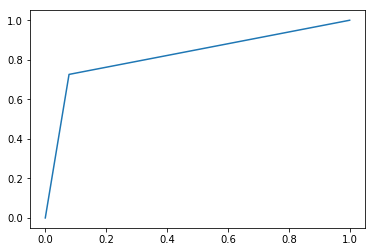

In [660]:
plt.plot(fpr, tpr)

In [661]:
accuracy_score(y_pred, y_test)

0.865211810012837

In [652]:
y_pred

array([1, 1, 0, ..., 0, 0, 0])